In [ ]:
!pip install -U pip wheel setuptools
!pip install concrete-ml

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [12]:
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score
from concrete.ml.sklearn import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegression as skLR
from sklearn.linear_model import LinearRegression as skLinear
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import pandas as pd

start_time = time.time()
def feature_selection(x, opt = "", var_percent = 0.8, n_features = 30):
    if opt == "var":
        print("\nUsing variance threshold feature selection...")
        # Remove all features that have low variance in more than (percent)% of the samples.
        sel = VarianceThreshold(threshold=(var_percent * (1 - var_percent)))
        print("Shape of X: ", x.shape)
        x = sel.fit_transform(x)
        print("After feature selection: ", len(x[0]), " features")
        cols_idxs = sel.get_support(indices=True)
    elif opt == "kbest":
        print("\nUsing K best features feature selection...")
        print("Shape of x before selection: ", x.shape)
        sel = SelectKBest(chi2, k=n_features)
        x = sel.fit_transform(x, y)
        print("Shape of x after selection: ", x.shape)
        cols_idxs = sel.get_support(indices=True)
    elif opt == "pca":
        print("\nUsing PCA feature selection...")
        x_scaled = StandardScaler().fit_transform(x)
        pca = PCA(n_components=n_features)
        pca_features = pca.fit_transform(x_scaled)
        print('Shape before PCA: ', x_scaled.shape)
        print('Shape after PCA: ', pca_features.shape)
        x = pca_features
        cols_idxs = pca.get_support(indices=True)
    else:
        print("")
    return x, cols_idxs

#select set option
set = -1

dataset = pd.read_csv("DATASET (06-16-2023) Includes Omicron and BA.1 and BA.2 Only.csv")

#print(dataset['Lineage'].value_counts())

#remove "EPI_ISL_" from ID
#new_ID_col = []
#for i in range(0, len(dataset['Accession ID'])):
#    new_ID_col.append(str(dataset['Accession ID'].loc[i].replace("EPI_ISL_", "")))
#dataset['Accession ID'] = new_ID_col

feature_cols = [c for c in dataset.columns[2:]]
#print(feature_cols)

x = dataset.loc[:,feature_cols].values #must be floats
y = dataset.loc[:,'Lineage'].values #must be integers

#print(x)
#print(y)

# Preprocessing with labels for the lineage
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

x = x.astype(float)

print("Shape of x: ", x.shape)
print("Shape of y:", y.shape)

print(f"Running time is {time.time() - start_time} seconds")

['B.1.1.529' 'BA.1' 'BA.2']
Shape of x:  (1584, 512)
Shape of y: (1584,)
Running time is 0.0593874454498291 seconds


In [13]:
print(dataset['Lineage'].value_counts())
print(f"Total: {dataset['Lineage'].count()}")

Lineage
BA.1         572
BA.2         515
B.1.1.529    497
Name: count, dtype: int64
Total: 1584


In [14]:
# Feature Selection Cell (ensemble attempted)

start_time = time.time()
#x = feature_selection(x, "var", var_percent = 0.80)
x, cols_idxs = feature_selection(x, "kbest", n_features = 15)
#x = feature_selection(x, "pca", n_features = 5)

# print(dataset.iloc[:,cols_idxs])

print("\nSelected features: ")
for col in cols_idxs:
    print(feature_cols[col])

print(f"Running time is {time.time() - start_time} seconds")


Using K best features feature selection...
Shape of x before selection:  (1584, 512)
Shape of x after selection:  (1584, 15)

Selected features: 
feature_24
feature_56
feature_57
feature_73
feature_76
feature_87
feature_140
feature_148
feature_157
feature_180
feature_268
feature_300
feature_317
feature_390
feature_479
Running time is 0.008870124816894531 seconds


In [15]:
# Retrieve train and test sets

def split(x,y):
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30)

    return X_train, X_test, y_train, y_test

start_time = time.time()
X_train, X_test, y_train, y_test = split(x,y)

print(f"Test set size: {X_test.shape}")

print(f"Running time is {time.time() - start_time} seconds")
#st_x = StandardScaler()
#X_train = st_x.fit_transform(X_train)
#X_test = st_x.transform(X_test)

Test set size: (476, 15)
Running time is 0.0010592937469482422 seconds


In [16]:
results = []
print("Getting performance metrics for scikit-learn model (Plaintext)...")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{skmodel.score(X_test,y_test)*100}")

for r in results:
    print(f"{r}")
#print("Accuracy for sklearn: ", skmodel.score(X_test,y_test)*100,"%")
#print(f"Running time is {time.time() - start_time} seconds")

quantized_results = []
print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)

    start_time = time.time()
    # Run the predictions on non-encrypted data as a reference
    y_pred_clear = model.predict(X_test)

    quantized_results.append(f"{model.score(X_test,y_test) * 100}")
    # print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
    # print(f"Running time is {time.time() - start_time} seconds")

for r in quantized_results:
    print(f"{r}")

fhe_results = []
print("Getting performance metrics for Concrete-ML model (FHE)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    #Fit the model
    model.fit(X_train, y_train)
    #print("Compiling...")
    model.compile(x)
    #print("model compiled!")
    y_pred_fhe = model.predict(X_test, fhe="execute")
    fhe_results.append(f"{accuracy_score(y_test, y_pred_fhe) * 100}%")

for r in fhe_results:
    print(f"{r}")

Getting performance metrics for scikit-learn model (Plaintext)...
90.12605042016807
86.5546218487395
89.07563025210085
88.4453781512605
90.96638655462185
87.39495798319328
89.91596638655463
86.34453781512606
86.1344537815126
88.65546218487394
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
90.33613445378151
88.4453781512605
88.4453781512605
87.81512605042016
87.81512605042016
87.81512605042016
89.28571428571429
89.07563025210085
89.07563025210085
88.65546218487394
Getting performance metrics for Concrete-ML model (FHE)...
86.34453781512606%
85.92436974789915%
88.65546218487394%
88.23529411764706%
90.33613445378151%
89.70588235294117%
88.8655462184874%
90.54621848739495%
86.34453781512606%
87.81512605042016%


In [17]:
# Get running time for training of models
print("Getting training time and number of iterations for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    start_time = time.time()
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    start_time = time.time()
    model.fit(X_train, y_train)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

Getting training time and number of iterations for scikit-learn model (Plaintext)...
0.021768808364868164
0.01956939697265625
0.026446819305419922
0.020136356353759766
0.02504706382751465
0.0296478271484375
0.030072689056396484
0.02288055419921875
0.018562793731689453
0.020142793655395508
Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...
0.048348426818847656
0.0476374626159668
0.04939627647399902
0.06314921379089355
0.051827430725097656
0.04424643516540527
0.04272341728210449
0.04577159881591797
0.045769691467285156
0.04413294792175293


In [18]:
print("Getting running time for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    start_time = time.time()
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (Quantized Plaintext)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (FHE)...")
fhe_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    model.compile(x)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    fhe_results.append(f"{time.time() - start_time}")

for r in fhe_results:
    print(f"{r}")

Getting running time for scikit-learn model (Plaintext)...
0.00017380714416503906
0.00012969970703125
0.00013494491577148438
0.00012063980102539062
0.00037407875061035156
0.0003509521484375
0.00013327598571777344
0.00013566017150878906
0.00017333030700683594
0.00017595291137695312
Getting running time for Concrete-ML model (Quantized Plaintext)...
0.00041961669921875
0.0003578662872314453
0.0003161430358886719
0.0003044605255126953
0.0003294944763183594
0.0008044242858886719
0.0012981891632080078
0.0010833740234375
0.00025272369384765625
0.0007741451263427734
Getting running time for Concrete-ML model (FHE)...
0.00042176246643066406
0.00036835670471191406
0.00038743019104003906
0.00046825408935546875
0.0003864765167236328
0.0007359981536865234
0.0004527568817138672
0.0014302730560302734
0.0005176067352294922
0.000392913818359375


In [19]:
# # Initialize model and fix the number of bits to used for quantization 

# model = LogisticRegression(C=1)

# # Fit the model
# model.fit(X_train, y_train)

# start_time = time.time()
# # Run the predictions on non-encrypted data as a reference
# y_pred_clear = model.predict(X_test)

# # Output (plaintext vs FHE):
# # print("In clear:  ", le.inverse_transform(y_pred_clear))
# # accuracy_score(y_test, y_pred_clear)
# print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
# print(f"Running time is {time.time() - start_time} seconds")

# #low/higly volatile accuracy may be attributed to small dataset and too many features 
# #(feature selection needed and more samples are required)
# print("PREDICTION:\n", y_pred_clear)
# print("ACTUAL:\n", y_test) 

# # Compile into a FHE model
# start_time = time.time()
# print("Compiling...")
# model.compile(x)
# print("model compiled!")
# print(f"Running time is {time.time() - start_time} seconds")

# # Run the inference in FHE
# start_time = time.time()
# print("Predicting in FHE...")
# y_pred_fhe = model.predict(X_test, fhe="execute")
# print("Accuracy rate for FHE:  ", accuracy_score(y_test, y_pred_fhe) * 100, "%")

# #print("In FHE    :", y_pred_fhe)
# print(f"Comparison: {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")
# print(f"Running time is {time.time() - start_time} seconds")

In [20]:
#Get AUC for multiclass
#NOTE WE HAVE A MULTICLASS BUT NOT MULTILABEL PROBLEM. only one label selected from multiple classes is assigned
start_time = time.time()
results = []
quantized_results = []
fhe_results = []

print("Getting performance metrics for scikit-learn model (Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    #start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))

for r in results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    quantized_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    #print("Compiling...")
    model.compile(x)
    fhe_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in fhe_results:
    print(f"{r}")

#print("Scikit learn ROC AUC Score (One vs Rest): ", roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))
#print("Scikit learn AUROC (One vs One): ", roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovo'))
#print("Macro-averaged Concrete-ML ROC AUC Score (One vs Rest): ", roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))
#print("Concrete-ML AUROC (One vs One): ", roc_auc_score(y, model.predict_proba(x), multi_class='ovo'))
#print(f"Running time is {time.time() - start_time} seconds")

Getting performance metrics for scikit-learn model (Plaintext)...
0.9697658603963716
0.9710038803317261
0.9693893498582259
0.9680113857060159
0.970393549958882
0.9675937341264783
0.9674987396424058
0.9695786426916131
0.9674092462268503
0.9681541584255968
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
0.9690764784620377
0.9712589228845679
0.967452424291097
0.9688594212290217
0.9668984297348081
0.9699486857202428
0.9679500524293493
0.9687882257515087
0.9691620354865655
0.9681121188012832
Getting performance metrics for Concrete-ML model (FHE)...
0.9687093839556397
0.9681953713744748
0.9704843650777688
0.9702288985684712
0.9686757578427475
0.9693615129386188
0.9669488742913833
0.9690478391870342
0.9699861733566172
0.9689722816089951


***Note: The diagonal elements are the correctly predicted samples. ***
Confusion matrix for SKLearn Plaintext: 


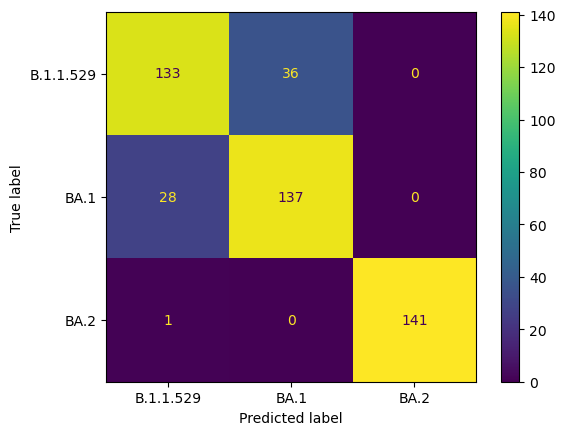

Confusion matrix for Quantized Plaintext: 


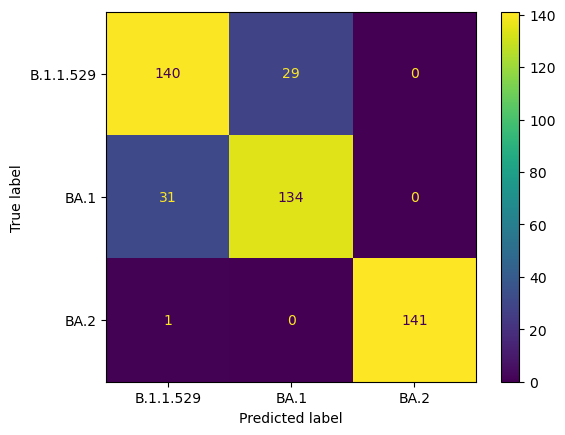

Confusion matrix for FHE: 


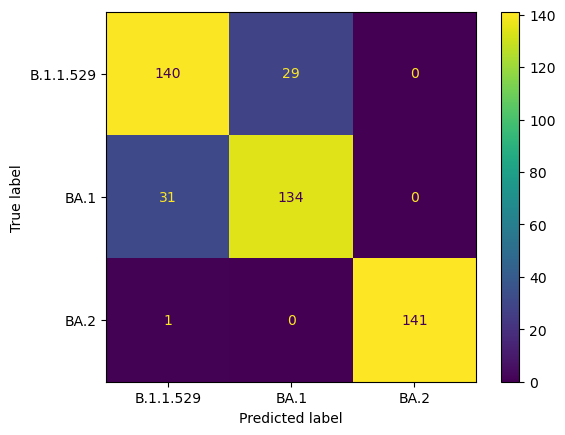

Running time is 1.0372962951660156 seconds
Comparison (FHE vs Plaintext): 97% similar
Comparison (FHE vs Quantized Plaintext): 100% similar


In [21]:
# In[10]:
start_time = time.time()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("***Note: The diagonal elements are the correctly predicted samples. ***")

#use the scikit-learn classes because we use the same class naman
X_train, X_test, y_train, y_test = split(x,y)

print("Confusion matrix for SKLearn Plaintext: ")
#print(confusion_matrix(y_test, y_pred_sklearn), "\n")
skmodel = skLR(C=1)
skmodel.fit(X_train,y_train)
y_pred_sklearn = skmodel.predict(X_test)
sklearn_cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sklearn), display_labels=le.classes_)
sklearn_cm_display.plot()
plt.show()

print("Confusion matrix for Quantized Plaintext: ")
#print(confusion_matrix(y_test, y_pred_clear), "\n")
model = LogisticRegression(C=1)
model.fit(X_train,y_train)
y_pred_clear = model.predict(X_test)
concrete_plain_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_clear), display_labels=le.classes_)
concrete_plain_display.plot()
plt.show()

print("Confusion matrix for FHE: ")
#print(confusion_matrix(y_test, y_pred_fhe))
model.compile(x)
y_pred_fhe = model.predict(X_test)
concrete_fhe_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_fhe), display_labels=le.classes_)
concrete_fhe_display.plot()
plt.show()

print(f"Running time is {time.time() - start_time} seconds")

print(f"Comparison (FHE vs Plaintext): {int((y_pred_fhe == y_pred_sklearn).sum()/len(y_pred_fhe)*100)}% similar")
print(f"Comparison (FHE vs Quantized Plaintext): {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")

In [22]:
from concrete.ml.sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC as skSVC
from concrete.ml.sklearn.rf import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as skRF

print(f"Sklearn Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)

    #SKLEARN LINEAR REGRESSION
    skmodel2 = skLinear()
    skmodel2.fit(X_train,y_train)
    skmodel2.predict(X_test)
    #print("Sklearn Linear Regression Accuracy: ", skmodel2.score(X_test,y_test)*100,"%")

    #SKLEARN RANDOM FOREST
    skmodel3 = skRF()
    skmodel3.fit(X_train, y_train)
    skmodel3.predict(X_test)
    #print("Sklearn Random Forest Accuracy: ",skmodel3.score(X_test,y_test)*100,"%")

    #SKLEARN SVC
    skmodel4 = skSVC()
    skmodel4.fit(X_train, y_train)
    skmodel4.predict(X_test)
    #print("Sklearn SVC Accuracy: ",skmodel4.score(X_test,y_test)*100,"%")

    print(f"{skmodel2.score(X_test,y_test)*100} {skmodel3.score(X_test,y_test)*100} {skmodel4.score(X_test,y_test)*100}")

print(f"Concrete-ML Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    model2.predict(X_test)
    print("Concrete-ML Linear Regression Accuracy: ", model2.score(X_test,y_test)*100,"%")

    model3 = RandomForestClassifier()
    model3.fit(X_train, y_train)
    model3.predict(X_test)
    print("Concrete-ML Random Forest Accuracy: ",model3.score(X_test,y_test)*100,"%")

    model4 = LinearSVC()
    model4.fit(X_train, y_train)
    model4.predict(X_test)
    print("Concrete-ML SVC Accuracy: ",model4.score(X_test,y_test)*100,"%")

    print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

Sklearn Accuracy (Linear Reg, RF, SVC):
83.06708030103881 89.91596638655463 87.60504201680672
84.99044654923641 90.54621848739495 88.02521008403362
86.72581185904514 91.80672268907563 89.91596638655463
83.7688818688865 90.75630252100841 86.76470588235294
86.51779652230604 91.17647058823529 89.49579831932773
83.7210640678848 90.75630252100841 88.4453781512605
83.61751255687437 89.70588235294117 88.02521008403362
85.65181257814481 89.91596638655463 90.12605042016807
84.32155980466622 89.49579831932773 87.60504201680672
84.24036852518098 90.54621848739495 90.96638655462185
Concrete-ML Accuracy (Linear Reg, RF, SVC):
Concrete-ML Linear Regression Accuracy:  84.07804209194798 %
Concrete-ML Random Forest Accuracy:  84.03361344537815 %
Concrete-ML SVC Accuracy:  82.14285714285714 %
84.07804209194798   84.03361344537815   82.14285714285714
Concrete-ML Linear Regression Accuracy:  85.95563965132492 %
Concrete-ML Random Forest Accuracy:  84.03361344537815 %
Concrete-ML SVC Accuracy:  89.49579831

In [ ]:
# In[10]:


#Attempting to save the model
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer

start_time = time.time()

fhemodel_dev = FHEModelDev("./concrete-covid-classifier", model)
fhemodel_dev.save()

print(f"Running time for saving the FHE model is {time.time() - start_time} seconds")

In [ ]:
#Saving Scikit-learn model
from joblib import dump, load

dump(skmodel, './scikit-learn-classifier/scikitlearnmodel.joblib')
#loaded_model = load('scikitlearnmodel.joblib')